<a href="https://colab.research.google.com/github/neuromatch/course-content-template/blob/main/projects/example_dataset/Example_based_on_CMA_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/course-content-template/main/projects/example_dataset/Example_based_on_CMA_structure" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

<h1>
Arctic Sea-ice Decline
</h1>



__Content creators:__ Alistair Duffey, Michel Tsamados, Will Gregory

__Content reviewers:__ Names & Surnames

__Content editors:__ Konstantinos Tsafatinos

__Production editors:__ Konstantinos Tsafatinos

__Our 2024 Sponsors:__ Sponsors


---
The notebook should have the following outline:

- Project background (video + template outline)
- Imports and functions common to multiple data sources
- Data source 1
- Data source background
- Imports and functions common to multiple datasets from the same data source

- Dataset 1:

    Dataset background (if needed)
    
    Imports and functions specific to the dataset
    
    Code to load the dataset
    
    Code to pre-process the dataset (if not taught and likely difficult for students)
    
    Code to visualise the data table shape/content

...
- Dataset N:
    same as for Dataset 1
...

- Further reading

---
We encourage you to explain the key parts of your code through comments and text cells as you see fit.

---
If the same or analogous dataset is covered in the curriculum tutorials, we can expect students to know how to load that data. In that case, please provide only the dataset background and refer students to the respective curriculum day while maintaining the structural hierarchy of the notebook.

---
If you wish to include any plots in your template, those should follow the standard figure formatting. Please include the Figure settings cell from the tutorial notebook template. Let us know if you have any questions about this or are unsure how to proceed!

To include videos:

In [ ]:
# @title Project Background

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')  
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '<video_id_1>'), ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

To include slides:

In [60]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
#link_id = "n7wdy"

In this project, you will be given the opportunity to explore data from climate models to examine the modelled change in sea ice coverage over time.

The project aims to:
* Download, process and plot data showing modelled sea ice coverage over the historical period from a CMIP6 model.
* Calculate the total sea ice extent and assess it's rate of decline over the recent historical period, and projected into the future under a middle-of-the-road emissions scenario.
* Assess the dependence of future projections on emissions scenario, e.g. to assess whether any emissions scenario is sufficient to keep late-summer sea ice in the Arctic.
* Examine the spatial and seasonal variation of sea-ice and how this changes during its decline with warming.

We also include a dataset of satellite observations, in case you would like to check the realism of the model's representaiton of sea ice in the recent historical period. 


# Project Template

<img src='../template-images/Sea_ice_template_questions.svg'/>

## Data Exploration Notebook

## Project Setup

In [ ]:
# google colab installs

# !mamaba install netCDF4

In [1]:
# Imports

#Import only the libraries/objects that are necessary for more than one dataset.
#Dataset-specific imports should be in the respective notebook section.

#If any external library has to be installed, !pip install library --quiet
#follow this order: numpy>matplotlib.
#import widgets in hidden Figure settings cell

import random
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask

In [3]:
# @title Figure settings

#import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

## [datasource 1]: Climate model simulations of sea ice concentration

Here we use output from CESM2-WACCM, the Community Earth System Model (version 2, CESM2), with the The Whole Atmosphere Community Climate Model (WACCM) as it's atmosphere component. 

We use the historical scenario, which runs with historical forcings 1850-2014. Note that this scenario is just one instance of internal variability under a world forced by historical GHGs. 

A note on the sea ice output for CMIP6 models: 

Sea ice component of models is generally output on the ocean grid, which is not normally a simple lat/lon grid, unlike many atmosphere model components. Here we use the variable 'siconca' which stands for 'sea ice concentration atmosphere' - this is the sea ice concentration regridded onto the model's atmosphere grid, and is somewhat easier to work with.


In [2]:
# read in the historical scenario run data 
# this is for one ensemble member - r1i1p1f1 
# and one scenario - 'historical' 
directory_mod = '/badc/cmip6/data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/SImon/siconca/gn/latest/'
files_mod = ['siconca_SImon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc']

SI_ds = xr.open_mfdataset([directory_mod + file for file in files_mod],
                                chunks=100)          

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'siconca' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    siconca    (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  20075.0
    case_id:                4
    ...                     ...
    sub_experiment_id:      none
    table_id:               SImon
    tracking_id:            hdl:21.14100/52972bca-08f2-4217-ac15-9ed5fb4c3a89
    variable_id:            siconca
    variant_info:           CMIP6 CESM2 hindcast (1850-2014) with high-top at...
    variant_label:          r1i1p1f1

In [18]:
# also get the models grid areas as an input file:
areacella_file = '/badc/cmip6/data/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc'
grid_cell_areas = xr.open_dataset(areacella_file)
grid_cell_areas

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [21]:
# files for the SSP2-4.5 scenario, for the orange extension questions:
directory_cmip_data_ssp245 = '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/SImon/siconca/gn/latest/'

files_cmip_data_ssp245 = ['siconca_SImon_CESM2-WACCM_ssp245_r1i1p1f1_gn_201501-206412.nc',
                   'siconca_SImon_CESM2-WACCM_ssp245_r1i1p1f1_gn_206501-210012.nc']      

In [50]:
# we can take a look at our dataset shape by calling it: 
SI_ds  

<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    siconca    (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  20075.0
    case_id:                4
    ...                     ...
    sub_experiment_id:      none
    table_id:               SImon
    tracking_id:            hdl:21.14100/52972bca-08f2-4217-ac15-9ed5fb4c3a89
    variable_id:            siconca
    variant_info:           CMIP6 CESM2 hindcast (1850-2014) with high-top at...
    variant_label:          r1i1p1f1

In [53]:
# we see that it contains the variable siconca

# lets print the minimum and maximum of this variable to check its format:
print(SI_ds.siconca.min().values)
print(SI_ds.siconca.max().values)
# note that it is formattwd as a percentage not a fraction, ranging from 0 to 100. 

0.0
99.999916


Great, now you are all set to use these model sea-ice data to address the questions you are interested in!

# Solutions for the Green questions

## Q1. 
Plot the seasonal mean (DJF, MAM, JJA, SON)
sea ice concentration fields from one CMIP6 ensemble member.

In [3]:
import cartopy.crs as ccrs
import cartopy as cy

Text(0, 0.5, '%')

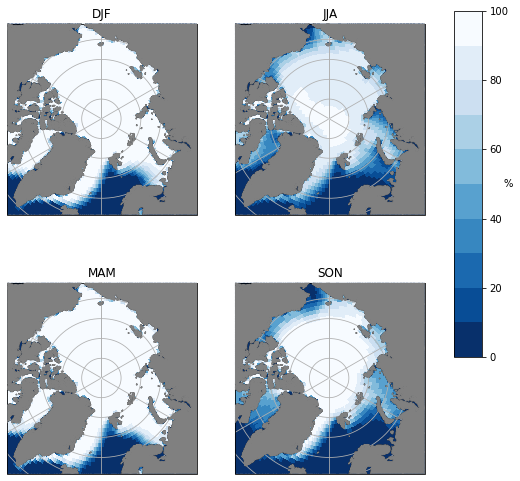

In [4]:
# we'll do this for the preindustrial period:
timeperiod = [1850, 1900]
SI_ds_PI = SI_ds.sel(time=slice('1850', '1900'))

# select northern hemisphere high latitudes:
SI_ds_PI = SI_ds_PI.sel(lat = slice(50, 90))

# now use groupby function to get seasonal means
SI_ds_PI = SI_ds_PI.groupby(SI_ds_PI.time.dt.season).mean()


# now plot
#fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig, axs = plt.subplots(2, 2, figsize=(8, 8), 
                    subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=0.0), 
                                'facecolor':'gray'})
i=0
for season in SI_ds_PI.season.values:
    ds = SI_ds_PI.isel(season=i)
    
    p = ds.siconca.plot.pcolormesh(ax=axs.flatten()[i],
                               levels=  np.arange(0, 110, 10),
                               cmap='Blues_r',
                               transform=ccrs.PlateCarree(), 
                               x="lon", y="lat", 
                               add_colorbar=False
                               )
    
    p.axes.set_extent([0, 360, 66, 90], ccrs.PlateCarree())
    axs.flatten()[i].gridlines()
    axs.flatten()[i].set_title(season)
    p.axes.coastlines()
    #p.axes.LAND()
    p.axes.add_feature(cy.feature.LAND, color='gray', zorder=1000)
    i = i+1
fig.subplots_adjust(right=0.85, top=0.95)
cbar_ax = fig.add_axes([0.9, 0.35, 0.05, 0.6])
cbar = fig.colorbar(p, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', rotation=0, 
                       verticalalignment='center', labelpad =0)

## Q2. 
For your CMIP6 model, compute the time series of mean sea ice extent over the period 1950-2014. Compute this for the months of March and September. 

We define sea ice extent following the convention that a grid cell is 'sea ice' where the concentration is higher than 15%. 

Extent is then the sum of the grid cell areas with concetration above 15%. 

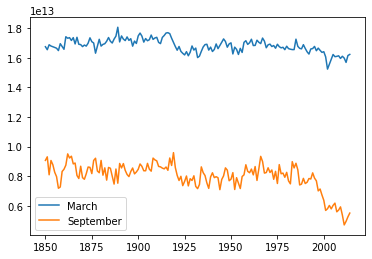

In [46]:
SI_ds_mar = SI_ds.where(SI_ds.time.dt.month == 3, drop=True)
SI_ds_sep = SI_ds.where(SI_ds.time.dt.month == 9, drop=True)

# now define a function to convert concentration to extent:
def get_extent(ds):
    SI_binary = xr.where(ds.siconca>15, 1, 0)
    SI_cells_areas = SI_binary*grid_cell_areas
    # take only northern hemisphere:
    SI_cells_areas = SI_cells_areas.sel(lat=slice(0, 90))
    SI_extent_timeseries = SI_cells_areas.areacella.sum(dim=['lat', 'lon'])
    return SI_extent_timeseries

SI_extent_mar = get_extent(SI_ds_mar)
SI_extent_sep = get_extent(SI_ds_sep)

# quick plot to check:
plt.plot(SI_extent_mar.time.dt.year, SI_extent_mar, label='March')
plt.plot(SI_extent_sep.time.dt.year, SI_extent_sep, label='September')
plt.legend()

Q3. Compute the linear trend in each sea ice extent time series between 1979-2014. Does the trend reflect a decline in sea ice extent within the model? Are these trends different between March and September? 


In [41]:
# we can use the scipy stats package to calculate linear trends and
# test for differences:
from scipy import stats

# also define a conversion from m2 to million km2, to make our units more interpretable:
unit_conversion_m2_Mkm2 = 10**(-12)

In [43]:
march_test = SI_extent_mar.sel(time=slice('1979', '2014'))
linear_regression_march = stats.linregress(march_test.time.dt.year, unit_conversion_m2_Mkm2*march_test.values)

september_test = SI_extent_sep.sel(time=slice('1979', '2014'))
linear_regression_september = stats.linregress(september_test.time.dt.year, unit_conversion_m2_Mkm2*september_test.values)

In [45]:
print(linear_regression_march)
print(linear_regression_september)

LinregressResult(slope=-0.026916248481935644, intercept=70.09838824698096, rvalue=-0.7085028184389062, pvalue=1.3324180848619235e-06, stderr=0.0045978893749957, intercept_stderr=9.179810401024811)
LinregressResult(slope=-0.10324355173521954, intercept=213.0497016999347, rvalue=-0.9053126699550053, pvalue=3.3882764111605495e-14, stderr=0.008307186154928226, intercept_stderr=16.58552167065367)


Both months show a negative trend, but the trend is around 5 times larger in september in this model. September sea ice is declining at around 1M km2 per decade in this model. 

The code below shows that if this continues, this model sees sea-ice free period in late summer around 2060:

In [49]:
x_intercept_sep = -linear_regression_september.intercept/linear_regression_september.slope
print(x_intercept_sep)

2063.5642431822394


# Further Reading

* On the CMIP6 projections for arctic sea ice, see Notz et al., 2020  https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019gl086749
* This paper by Steove & Notz, is a nice summary of the observational trends across all seasons, and how they compare to models' predictions: https://iopscience.iop.org/article/10.1088/1748-9326/aade56



# Optional additional data source 2: Satellite observations

National Snow & Ice Data (NSIDC) 
Gridded Monthly Sea Ice Extent and Concentration, 1850 Onward, Version 2
https://doi.org/10.7265/jj4s-tq79

From 1978, this is satellite passive microwave data. Prior to this, a range of sources are used (e.g. ship logs), but we will subset to only the satellite era here. 

The passive microwave observations are the NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4. This data product uses a combination of two algorithms to generate the sea ice concentration; the NASA Team (NT) algorithm (Cavalieri et al. 1984), and the NASA Bootstrap (BT) algorithm (Comiso 1986). 

This version has been gridded onto a 1/4 degree latitude-longitude grid, and has been averaged to monthly resolution. It includes only latitudes North of 30°N (so is arctic-only).

In [54]:
# Code to retrieve and load the data
Sea_ice_conc_obs_file = 'Data/G10010_sibt1850_v2.0.nc'
SI_obs_ds = xr.open_dataset(Sea_ice_conc_obs_file, chunks=100)

# note the use of the chunks keyword. These data come on a high resolution grid, 
# so are potentially too large to load into memory. Chunking (using dask) 
# avoids this problem. We arbitrarily pick a chunk length of 100 along each dimension.     

# we can print a useful summary of the data by calling it:
SI_obs_ds

,Array,Chunk
Bytes,664.45 MiB,0.95 MiB
Shape,"(2016, 240, 1440)","(100, 100, 100)"
Count,946 Tasks,945 Chunks
Type,uint8,numpy.ndarray
,Array,Chunk
Bytes,664.45 MiB,0.95 MiB
Shape,"(2016, 240, 1440)","(100, 100, 100)"
Count,946 Tasks,945 Chunks
Type,uint8,numpy.ndarray
,Array,Chunk


In [55]:
# Code to preprocess data
# we will select only the satellite era observations:
SI_obs_ds = SI_obs_ds.where(SI_obs_ds.time.dt.year > 1978, drop=True)

We can now visualize the content of the dataset:

Note that the sea ice concentration is (confusingly!) set to 120% over land. 

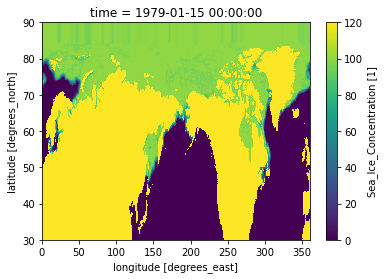

In [57]:
# We can select and plot the first month 
# using .isel(time=0) and inbuilt xarray plotting,
# just to check the data looks reasonable:
SI_obs_ds.isel(time=0).seaice_conc.plot()

Note that the dataset also includes variables for grid cell area. Grid cell area is in km2. 

We will need this to convert the spatial data into a timeseries of total Arctic sea ice area. 

The code below shows how this can be done:

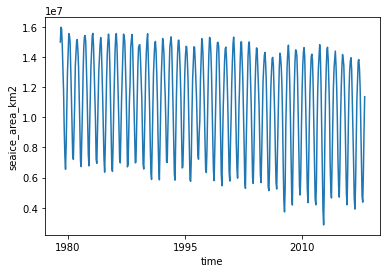

In [59]:
# select only the ocean regions by ignoring any percentages over 100:
SI_obs_ds = SI_obs_ds.where(SI_obs_ds['seaice_conc'] < 101)

# then multiple the ice fraction in each grid cell by the cell area:
# factor of 0.01 to convert from percentage to fraction
SI_obs_ds['seaice_area_km2'] = 0.01*SI_obs_ds['seaice_conc']*SI_obs_ds['Gridcell_Area']

# finally, we can sum this sea-ice area variable over the spatial dimensions to get
# a timeseries of total Arctic sea ice area:
SI_total_area_obs = SI_obs_ds['seaice_area_km2'].sum(dim=['latitude', 'longitude'])
SI_total_area_obs.plot()

Now you can add the observational decline of sea ice to your analysis if you wish!